# Function 4: 4D Warehouse Logistics

*Analogy: **Many local optima**; output vs expensive baseline. We **maximize** \(y\) (e.g. throughput or reward vs baseline).*

### Characteristics

* **4D input**: \((x_1, x_2, x_3, x_4)\) — e.g. layout or routing parameters in \([0,1]^4\).

* **Objective**: Maximize \(y\). Initial data: 30 points, shape (30, 4).

* **Strategy**: Same Bayesian optimisation workflow — GP surrogate, EI/PI/UCB acquisition — in 4D; visualisation uses 2D pairwise plots (no single 3D scatter).


## 1. Setup and load data (read-only from initial_data)

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, Matern, WhiteKernel
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")


# Project root: works whether you run from repo root or from notebooks/
repo_root = Path.cwd() if (Path.cwd() / "src").exists() else Path.cwd().parent
sys.path.insert(0, str(repo_root))

from src.utils.load_challenge_data import (
    load_function_data, 
    assert_not_under_initial_data
)
from src.optimizers.bayesian.acquisition_functions import (
    entropy_search,
    expected_improvement,
    probability_of_improvement,
    thompson_sampling_sample,
    upper_confidence_bound,
)
from src.utils.plot_utilities import (
    add_colorbar,
    style_axis,
    style_axis_3d,
    style_legend,
    DEFAULT_FONT_SIZE_AXIS,
    DEFAULT_FONT_SIZE_TITLES,
    DEFAULT_EXPORT_DPI,
    DEFAULT_EXPORT_FORMAT,
)

# --- Plot options; font/export defaults from utils (DEFAULT_*) ---
IF_SHOW_PLOT = True
IF_EXPORT_PLOT = True
PLOT_EXPORT_DIR = repo_root / "data" / "results"

IF_EXPORT_QUERIES = True
IF_APPEND_DATA = False

# Set seed for reproducibility
np.random.seed(42)

In [2]:
# Load: prefer local appended data (inputs.npy/outputs.npy), else initial local copy, else initial_data (read-only)
local_dir = repo_root / "data" / "problems" / "function_4"
local_inputs = local_dir / "inputs.npy"
local_outputs = local_dir / "outputs.npy"
if local_inputs.exists() and local_outputs.exists():
    X = np.load(local_inputs)
    y = np.load(local_outputs)
    if y.ndim > 1:
        y = y.squeeze()
    print("Loaded from local data (initial + appended):", local_dir)
else:
    local_inputs = local_dir / "initial_inputs.npy"
    local_outputs = local_dir / "initial_outputs.npy"
    if local_inputs.exists() and local_outputs.exists():
        X = np.load(local_inputs)
        y = np.load(local_outputs)
        if y.ndim > 1:
            y = y.squeeze()
        print("Loaded from local data (initial):", local_dir)
    else:
        X, y = load_function_data(function_id=4)
        print("Loaded from initial_data (read-only). Run 'Append data' after portal feedback to build local dataset.")

print('Dataset info:')
print('Location of the dataset: ', local_dir)
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"X max value: {X.max():.6f}")
print(f"X min value: {X.min():.6f}")
print(f"y max value: {y.max():.6f}")
print(f"y min value: {y.min():.6f}")

Loaded from initial_data (read-only). Run 'Append data' after portal feedback to build local dataset.
Dataset info:
Location of the dataset:  /Users/nikolaskarefyllidis/Desktop/60_ML:AI/10 main optimization/10 ICL BBO Challenge/black-box-optimization/data/problems/function_4
X shape: (30, 4)
y shape: (30,)
X max value: 0.999483
X min value: 0.006250
y max value: -4.025542
y min value: -32.625660


## 2. Visualize the initial points

Plot saved to /Users/nikolaskarefyllidis/Desktop/60_ML:AI/10 main optimization/10 ICL BBO Challenge/black-box-optimization/data/results/function_4_observations_2d_pairs.png


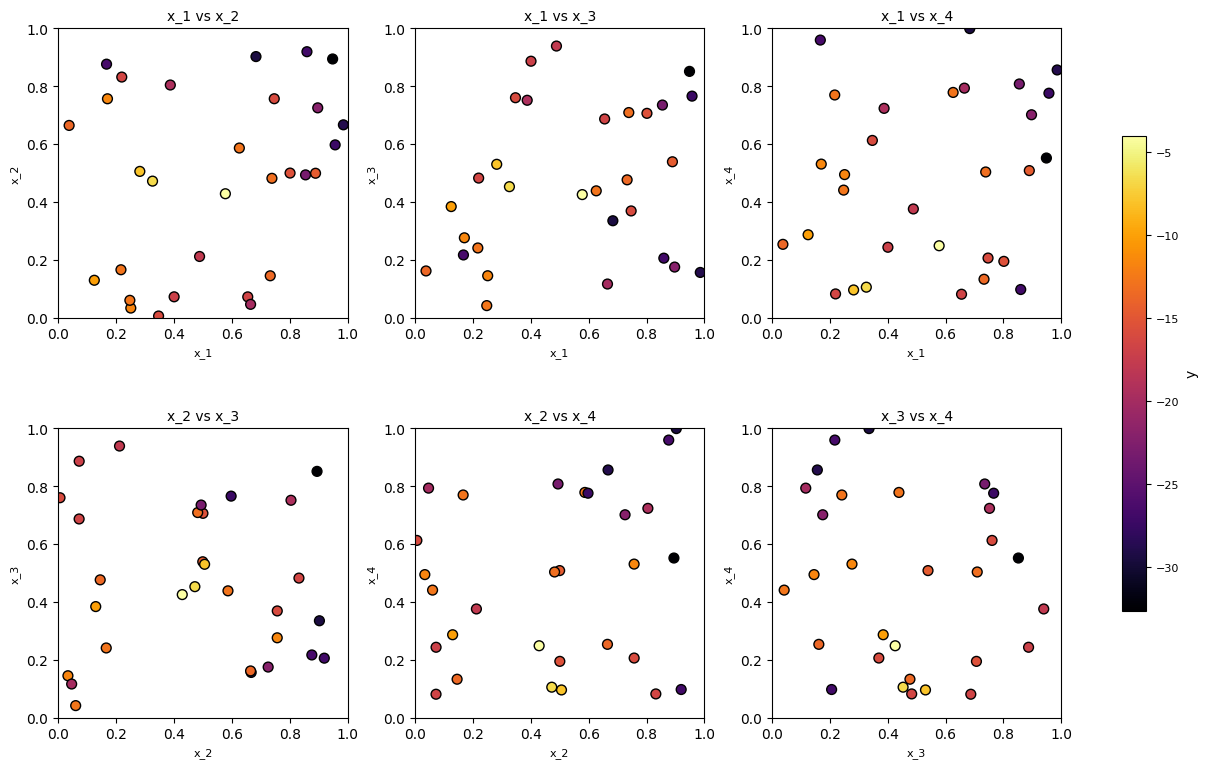

In [3]:
# 4D Warehouse Logistics: visualise observations (2D pairwise only; no single 3D scatter for 4D)
# Candidate set for GP/acquisition (4D): random sample in [0,1]^4
n_cand = 2000
candidate_pts = np.random.RandomState(42).uniform(0, 1, (n_cand, 4))
# Distance from each candidate to nearest observation (for baseline "high distance" suggestion)
diff = candidate_pts[:, None, :] - X[None, :, :]  # (n_cand, n_obs, 4)
dists = np.sqrt((diff ** 2).sum(axis=2))
min_dist = np.min(dists, axis=1)  # (n_cand,)

# 2D pairwise plots: all 6 pairs (x_1 vs x_2, x_1 vs x_3, x_1 vs x_4, x_2 vs x_3, x_2 vs x_4, x_3 vs x_4)
fig2, axes = plt.subplots(2, 3, figsize=(12, 8), constrained_layout=True)
axes = axes.ravel()
pairs = [(0, 1, "x_1", "x_2"), (0, 2, "x_1", "x_3"), (0, 3, "x_1", "x_4"), (1, 2, "x_2", "x_3"), (1, 3, "x_2", "x_4"), (2, 3, "x_3", "x_4")]
for ax, (i, j, li, lj) in zip(axes, pairs):
    sc = ax.scatter(X[:, i], X[:, j], c=y, s=50, cmap="inferno", edgecolors="k")
    style_axis(ax, xlabel=li, ylabel=lj, title=f"{li} vs {lj}", font_size_axis=DEFAULT_FONT_SIZE_AXIS, font_size_titles=DEFAULT_FONT_SIZE_TITLES)
    ax.set_aspect("equal")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
sm = plt.cm.ScalarMappable(norm=plt.Normalize(y.min(), y.max()), cmap="inferno")
sm.set_array(y)
cbar = fig2.colorbar(sm, ax=axes, shrink=0.6, label="y")
cbar.ax.tick_params(labelsize=DEFAULT_FONT_SIZE_AXIS)

if IF_EXPORT_PLOT:
    out_dir = PLOT_EXPORT_DIR
    assert_not_under_initial_data(out_dir, project_root=repo_root)
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path_2d = out_dir / f"function_4_observations_2d_pairs.{DEFAULT_EXPORT_FORMAT}"
    fig2.savefig(out_path_2d, dpi=DEFAULT_EXPORT_DPI, format=DEFAULT_EXPORT_FORMAT)
    print("Plot saved to", out_path_2d)
if IF_SHOW_PLOT:
    plt.show()

## 3. Suggest next point to submit, using Bayesian Optimization Methodology

### 3.1 The Probabilistic Surrogate Models

 * **Gaussian Process (GP)** — we compare three kernel choices below; each gives a different prior over functions and uncertainty:

    - **RBF kernel** — Smooth, infinitely differentiable prior; single length-scale. *Differs:* no explicit noise term (fixed small `alpha` for stability).

    - **Matérn kernel (ν=1.5)** — Less smooth than RBF; allows rougher, more "wiggly" surfaces. *Differs:* better when the true function has sharper changes or only finitely many derivatives.

    - **RBF + WhiteKernel** — Same smoothness as RBF but adds a separate noise term. *Differs:* explicitly models observation noise; uncertainty splits into noise vs interpolation.

In [4]:
# Coefficients of the Probabilistic Surrogate Models (used by GP kernels and acquisition functions below)

# --- GP / kernel (surrogate) ---
CONSTANT_KERNEL_SCALE = 1.0       # signal variance (output scale); typical: 0.1–10
LENGTH_SCALE = 0.1                # correlation length; typical for [0,1]²: 0.1–1
GP_ALPHA = 1e-6                   # diagonal jitter for numerical stability; typical: 1e-8–1e-4
MATERN_NU = 1.5                   # Matérn smoothness (1.5 = once differentiable); typical: 0.5, 1.5, 2.5
WHITE_NOISE_LEVEL = 1e-6         # WhiteKernel observation noise; typical: 1e-8–1e-2

# --- Acquisition functions ---   # Large XI_EI_PI = more exploration (start with EI + max exploration)
XI_EI_PI = 0.1                   # exploration bonus for EI, PI; 0.1 = strong exploration [0.01–0.2]
KAPPA_UCB = 4.0                   # UCB: weight on std (μ + κσ); typical: [0.1–4]

In [5]:
# Gaussian Process Regression on 4D (run after visualization cell so candidate_pts exist)
# Coefficients from cell above: CONSTANT_KERNEL_SCALE, LENGTH_SCALE, GP_ALPHA
kernel_RBF = ConstantKernel(CONSTANT_KERNEL_SCALE) * RBF(length_scale=LENGTH_SCALE)
gp_RBF = GaussianProcessRegressor(kernel=kernel_RBF, alpha=GP_ALPHA)
gp_RBF.fit(X, y)
# Predict on 4D candidate set (1D arrays of length n_cand)
mu_gp_RBF, sigma_gp_RBF = gp_RBF.predict(candidate_pts, return_std=True)

Plot saved to /Users/nikolaskarefyllidis/Desktop/60_ML:AI/10 main optimization/10 ICL BBO Challenge/black-box-optimization/data/results/function_4_gp_slices.png


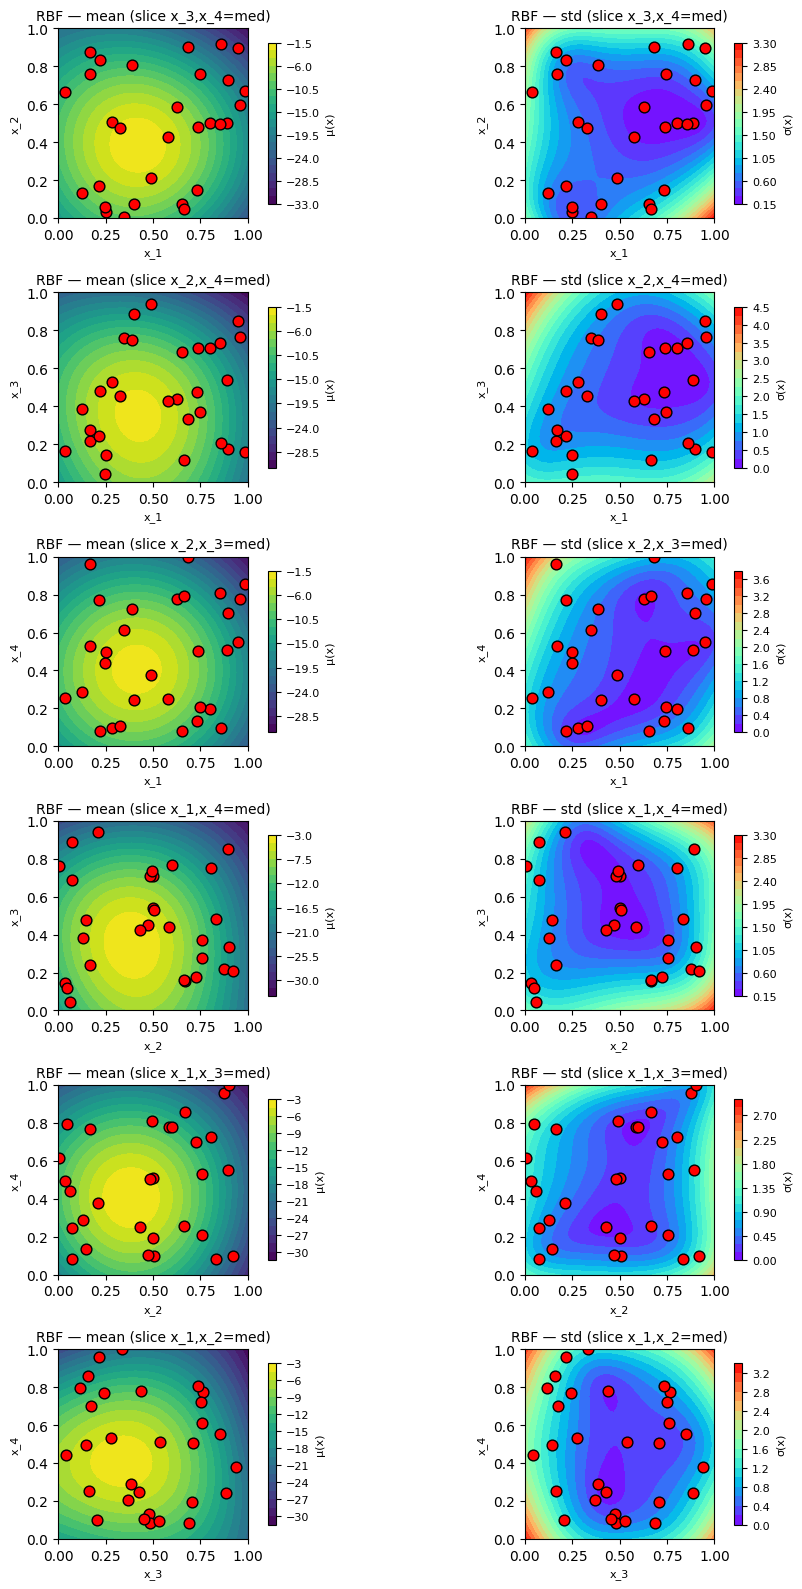

In [6]:
# Plot RBF GP on 2D slices for all six 4D pairs (mean and std contours)
# 4D: fix two dims at median; vary (x_i, x_j) for pairs (0,1), (0,2), (0,3), (1,2), (1,3), (2,3)
n_slice = 50
ug = np.linspace(0, 1, n_slice)
Ug, Vg = np.meshgrid(ug, ug)
med = [np.median(X[:, k]) for k in range(4)]

pairs = [(0, 1, "x_1", "x_2"), (0, 2, "x_1", "x_3"), (0, 3, "x_1", "x_4"), (1, 2, "x_2", "x_3"), (1, 3, "x_2", "x_4"), (2, 3, "x_3", "x_4")]
slices_info = []
for ia, ib, la, lb in pairs:
    other = [k for k in range(4) if k not in (ia, ib)]
    slice_pts = np.zeros((Ug.size, 4))
    slice_pts[:, ia] = Ug.ravel()
    slice_pts[:, ib] = Vg.ravel()
    slice_pts[:, other[0]] = med[other[0]]
    slice_pts[:, other[1]] = med[other[1]]
    slice_label = f"x_{other[0]+1},x_{other[1]+1}=med"
    slices_info.append((slice_pts, Ug, Vg, ia, ib, la, lb, slice_label))

fig, axes = plt.subplots(6, 2, figsize=(10, 16))
for row, (slice_pts, Ag, Bg, ia, ib, la, lb, slice_label) in enumerate(slices_info):
    mu_slice, sigma_slice = gp_RBF.predict(slice_pts, return_std=True)
    mu_slice = mu_slice.reshape(Ug.shape)
    sigma_slice = sigma_slice.reshape(Ug.shape)
    ax_mu, ax_sig = axes[row, 0], axes[row, 1]
    cf1 = ax_mu.contourf(Ag, Bg, mu_slice, levels=20, cmap="viridis")
    add_colorbar(cf1, ax=ax_mu, label="μ(x)", font_size_axis=DEFAULT_FONT_SIZE_AXIS, shrink=0.85)
    ax_mu.scatter(X[:, ia], X[:, ib], c="red", s=60, edgecolors="k")
    style_axis(ax_mu, xlabel=la, ylabel=lb, title=f"RBF — mean (slice {slice_label})", font_size_axis=DEFAULT_FONT_SIZE_AXIS, font_size_titles=DEFAULT_FONT_SIZE_TITLES)
    ax_mu.set_aspect("equal")
    cf2 = ax_sig.contourf(Ag, Bg, sigma_slice, levels=20, cmap="rainbow")
    add_colorbar(cf2, ax=ax_sig, label="σ(x)", font_size_axis=DEFAULT_FONT_SIZE_AXIS, shrink=0.85)
    ax_sig.scatter(X[:, ia], X[:, ib], c="red", s=60, edgecolors="k")
    style_axis(ax_sig, xlabel=la, ylabel=lb, title=f"RBF — std (slice {slice_label})", font_size_axis=DEFAULT_FONT_SIZE_AXIS, font_size_titles=DEFAULT_FONT_SIZE_TITLES)
    ax_sig.set_aspect("equal")
plt.tight_layout()
if IF_EXPORT_PLOT:
    out_dir = PLOT_EXPORT_DIR
    assert_not_under_initial_data(out_dir, project_root=repo_root)
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / f"function_4_gp_slices.{DEFAULT_EXPORT_FORMAT}"
    fig.savefig(out_path, dpi=DEFAULT_EXPORT_DPI, format=DEFAULT_EXPORT_FORMAT)
    print("Plot saved to", out_path)
if IF_SHOW_PLOT:
    plt.show()  

### 3.2 The Acquisition Functions $\alpha$(x)

* Expected Improvement (EI)

* Upper Confidence Bound (UCB)

* Probability of Improvement (PI)

In [7]:
# ACQUISITION FUNCTION(s) — on 4D candidate_pts (mu_gp_RBF, sigma_gp_RBF are 1D arrays of length n_cand)

# --- EXPECTED IMPROVEMENT: EI = E[max(f(x) − f(x⁺), 0)] ---
y_best_EI = y.max()
EI_RBF = expected_improvement(mu_gp_RBF, sigma_gp_RBF, y_best_EI, xi=XI_EI_PI)
x_best_EI_RBF = candidate_pts[np.argmax(EI_RBF)]

# --- UPPER CONFIDENCE BOUND: UCB = μ(x) + κσ(x) ---
UCB_RBF = upper_confidence_bound(mu_gp_RBF, sigma_gp_RBF, kappa=KAPPA_UCB)
x_best_UCB_RBF = candidate_pts[np.argmax(UCB_RBF)]

# --- PROBABILITY OF IMPROVEMENT: PI = P(f(x) > f(x⁺)) ---
PI_RBF = probability_of_improvement(mu_gp_RBF, sigma_gp_RBF, y_best_EI, xi=XI_EI_PI)
x_best_PI_RBF = candidate_pts[np.argmax(PI_RBF)]

# --- THOMPSON SAMPLING ---
sample_thompson_RBF = thompson_sampling_sample(mu_gp_RBF, sigma_gp_RBF)
x_thomson_RBF = candidate_pts[np.argmax(sample_thompson_RBF)]

# --- ENTROPY SEARCH ---
ES_RBF = entropy_search(mu_gp_RBF, sigma_gp_RBF, y_best_EI, xi=XI_EI_PI)
x_entropy_RBF = candidate_pts[np.argmax(ES_RBF)]


In [8]:
# Baseline: suggest next x without GP — point with highest distance to nearest observation (explore far from data).
idx_high_dist = np.argmax(min_dist)
next_x_high_dist = np.asarray(candidate_pts[idx_high_dist]).ravel()
next_x_high_dist = np.clip(next_x_high_dist, 0.0, 0.999999)
next_x = next_x_high_dist
print("Suggested next x (high distance to obs):", next_x)


Suggested next x (high distance to obs): [0.00637904 0.97835479 0.96574721 0.3951553 ]


## 4. Illustrate the locations on the proposed query

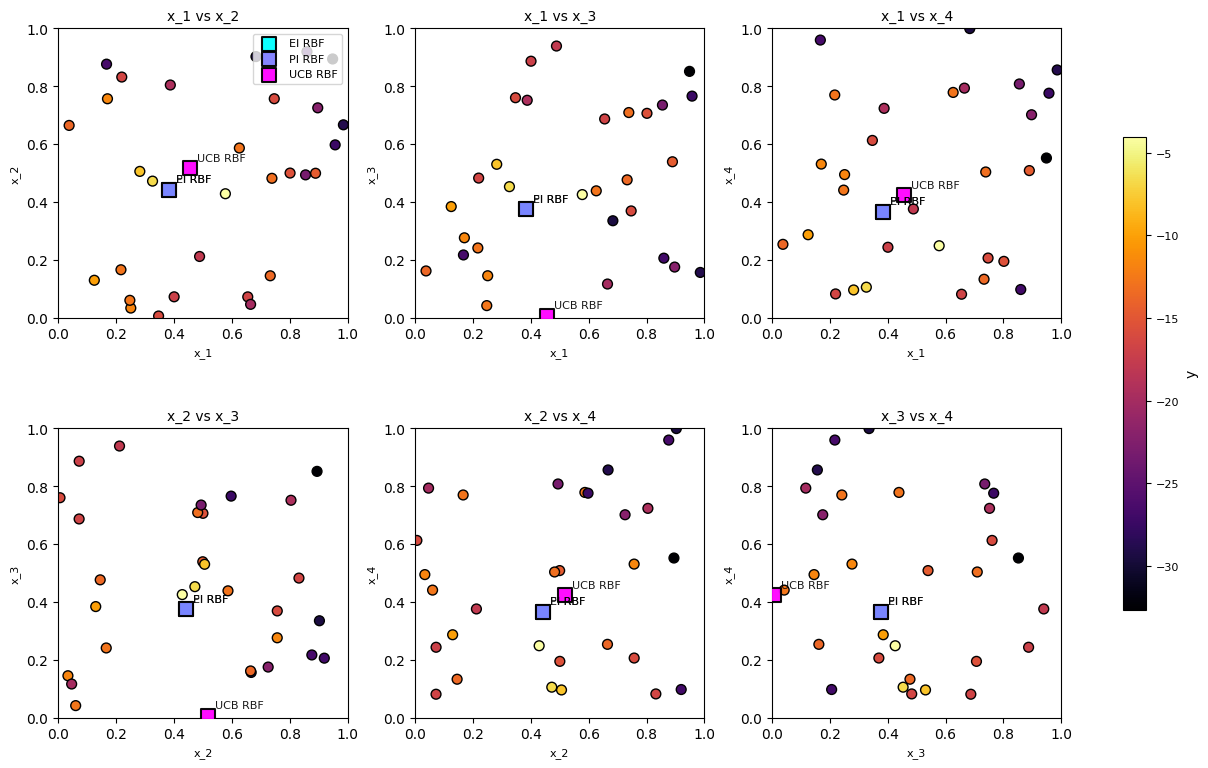

Plot saved to /Users/nikolaskarefyllidis/Desktop/60_ML:AI/10 main optimization/10 ICL BBO Challenge/black-box-optimization/data/results/function_4_acquisition_points_2d_pairs.png


In [9]:
# PLOT EI + PI + UCB (acquisition next points) — 4D: 2D pairwise only (6 pairs, no 3D scatter)

X_best_combined = np.array([x_best_EI_RBF, x_best_PI_RBF, x_best_UCB_RBF])
labels_combined = ['EI RBF', 'PI RBF', 'UCB RBF']
colors_combined = plt.cm.cool(np.linspace(0, 1, len(X_best_combined)))

# 2D pairwise view (all 6 pairs) — same layout as observations
fig2, axes = plt.subplots(2, 3, figsize=(12, 8), constrained_layout=True)
axes = axes.ravel()
pairs = [(0, 1, "x_1", "x_2"), (0, 2, "x_1", "x_3"), (0, 3, "x_1", "x_4"), (1, 2, "x_2", "x_3"), (1, 3, "x_2", "x_4"), (2, 3, "x_3", "x_4")]
for ax, (i, j, li, lj) in zip(axes, pairs):
    sc = ax.scatter(X[:, i], X[:, j], c=y, s=50, cmap="inferno", edgecolors="k", zorder=2)
    for k, (pt, lbl) in enumerate(zip(X_best_combined, labels_combined)):
        ax.scatter(pt[i], pt[j], c=[colors_combined[k]], s=100, marker='s', edgecolors="k", linewidths=1.5, alpha=0.95, label=lbl, zorder=3)
        ax.annotate(lbl, (pt[i], pt[j]), xytext=(5, 5), textcoords="offset points", fontsize=DEFAULT_FONT_SIZE_AXIS, alpha=0.9, zorder=4)
    style_axis(ax, xlabel=li, ylabel=lj, title=f"{li} vs {lj}", font_size_axis=DEFAULT_FONT_SIZE_AXIS, font_size_titles=DEFAULT_FONT_SIZE_TITLES)
    ax.set_aspect("equal")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
axes[0].legend(loc="upper right", fontsize=DEFAULT_FONT_SIZE_AXIS)
sm = plt.cm.ScalarMappable(norm=plt.Normalize(y.min(), y.max()), cmap="inferno")
sm.set_array(y)
cbar = fig2.colorbar(sm, ax=axes, shrink=0.6, label="y")
cbar.ax.tick_params(labelsize=DEFAULT_FONT_SIZE_AXIS)

if IF_SHOW_PLOT:
    plt.show()
if IF_EXPORT_PLOT:
    out_dir = PLOT_EXPORT_DIR
    assert_not_under_initial_data(out_dir, project_root=repo_root)
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path_2d = out_dir / f"function_4_acquisition_points_2d_pairs.{DEFAULT_EXPORT_FORMAT}"
    fig2.savefig(out_path_2d, dpi=DEFAULT_EXPORT_DPI, format=DEFAULT_EXPORT_FORMAT)
    print("Plot saved to", out_path_2d)


## 5. Choose next query

Pick the next input to submit. **EI RBF** (Expected Improvement with RBF kernel) is the default. **Strategy:** Start with EI and **max exploration** — in the coefficients cell (Section 3.1), `XI_EI_PI = 0.1` gives strong exploration (higher than the usual 0.01); you can try 0.2 for even more. See how it goes; later you can lower it for more exploitation. Alternative: `next_x_high_dist` (high distance to obs — explore unexplored regions).

In [10]:
# In this cell we select the next query to submit (4D: x_1, x_2, x_3, x_4).
# EI RBF = Expected Improvement with RBF kernel (default). Alternative: next_x_high_dist (high distance to obs).
next_x = x_best_EI_RBF  # or next_x_high_dist for high distance to obs
next_x = np.clip(np.asarray(next_x).ravel(), 0.0, 0.999999)
print(f"Next query (EI RBF): ({next_x[0]:.4f}, {next_x[1]:.4f}, {next_x[2]:.4f}, {next_x[3]:.4f})")

Next query (EI RBF): (0.3824, 0.4431, 0.3762, 0.3673)


## 6. Append new feedback (after portal returns)

After you submit and receive the new **(x, y)** from the portal for Function 4, paste the values below and run this cell. It appends to a local dataset under `data/problems/function_4/`. The next time you run the notebook from the top, section 1 will load from this local dataset (initial + all appended points).

In [11]:
if not IF_APPEND_DATA:
    print("IF_APPEND_DATA is False; append skipped. Set IF_APPEND_DATA = True and paste portal feedback below to run.")
else:
    # Paths (use repo_root from setup cell)
    _local_dir = repo_root / "data" / "problems" / "function_4"
    assert_not_under_initial_data(_local_dir, project_root=repo_root)
    _local_inputs = _local_dir / "inputs.npy"
    _local_outputs = _local_dir / "outputs.npy"

    # Set these from the portal feedback for Function 4 (one new input x_1,x_2,x_3,x_4 and one new output)
    x_new = np.array([0.5, 0.5, 0.5, 0.5], dtype=np.float64)  # replace with your submitted input (4D)
    y_new = 0.0  # replace with the output returned by portal (scalar)

    # Load current data (local if exists, else initial_data)
    if _local_inputs.exists() and _local_outputs.exists():
        X_cur = np.load(_local_inputs)
        y_cur = np.load(_local_outputs)
        if y_cur.ndim > 1:
            y_cur = y_cur.squeeze()
    else:
        X_cur, y_cur = load_function_data(function_id=4)

    # Append: one new row for inputs, one new value for outputs
    x_new = np.atleast_2d(x_new)
    X_updated = np.vstack((X_cur, x_new))
    y_updated = np.append(y_cur, y_new)

    # Save to local directory (do not overwrite read-only initial_data)
    _local_dir.mkdir(parents=True, exist_ok=True)
    np.save(_local_dir / "inputs.npy", X_updated)
    np.save(_local_dir / "outputs.npy", y_updated)
    print("Appended. Total points:", len(y_updated))
    print("Saved to", _local_dir)

IF_APPEND_DATA is False; append skipped. Set IF_APPEND_DATA = True and paste portal feedback below to run.


## 7. Save suggestion for submission

Write the chosen x to `data/submissions/` so you can upload it to the portal. **Portal format:** `x1-x2-...-xn` with **exactly six decimal places**, values in [0, 0.999999], **hyphens only, no spaces** (e.g. `0.498317-0.625531`). After you receive the new y, run section 6 (Append new feedback) to add it to your dataset, then re-run the notebook for the next round.

In [12]:
if IF_EXPORT_QUERIES:
    # Portal format: each value 0.XXXXXX (exactly 6 decimals), in [0, 0.999999], hyphen-separated, no spaces
    next_x_clip = np.clip(np.asarray(next_x, dtype=np.float64).ravel(), 0.0, 0.999999)
    portal_str = "-".join(f"{v:.6f}" for v in next_x_clip)
    out_dir = repo_root / "data" / "submissions" / "function_4"
    assert_not_under_initial_data(out_dir, project_root=repo_root)
    out_dir.mkdir(parents=True, exist_ok=True)
    np.save(out_dir / "next_input.npy", next_x_clip)
    (out_dir / "next_input_portal.txt").write_text(portal_str)
    print("Saved to", out_dir / "next_input.npy")
    print("Portal string (copy-paste to portal):", portal_str)
    print("Also saved to", out_dir / "next_input_portal.txt")
else:
    print("IF_EXPORT_QUERIES is False; next_input.npy not saved.")

Saved to /Users/nikolaskarefyllidis/Desktop/60_ML:AI/10 main optimization/10 ICL BBO Challenge/black-box-optimization/data/submissions/function_4/next_input.npy
Portal string (copy-paste to portal): 0.382363-0.443127-0.376190-0.367341
Also saved to /Users/nikolaskarefyllidis/Desktop/60_ML:AI/10 main optimization/10 ICL BBO Challenge/black-box-optimization/data/submissions/function_4/next_input_portal.txt
